In [14]:

import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns


file_path = '../data/raw/customer_data.csv'
df = pd.read_csv(file_path)


features = ['age', 'avg_monthly_spend', 'items_purchased_last_6_months']
X = df[features]

print("Data loaded and features selected.")
print(X.head())

Data loaded and features selected.
   age  avg_monthly_spend  items_purchased_last_6_months
0   27            4609.93                              3
1   46            4219.83                              3
2   35            5338.38                              5
3   70            5611.21                              7
4   23            5125.19                              5


In [15]:

scaler = StandardScaler()


X_scaled = scaler.fit_transform(X)

print("\nFeatures have been scaled.")


Features have been scaled.


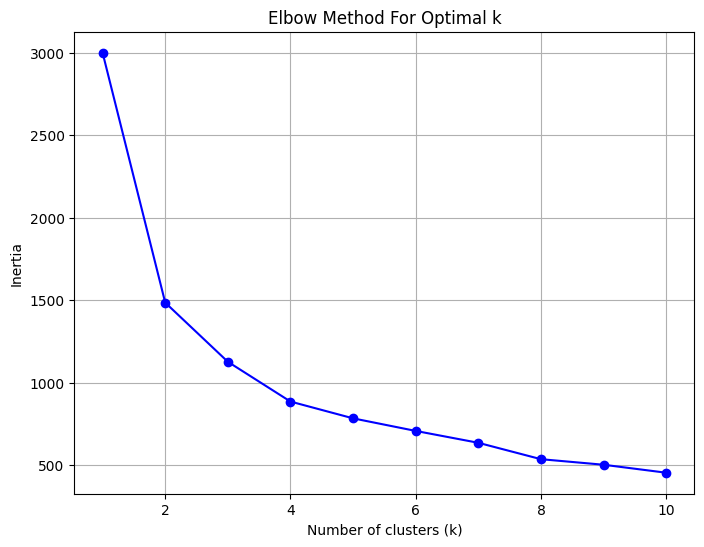

In [16]:

inertia = []
K = range(1, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init='auto', random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)


plt.figure(figsize=(8, 6))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.grid(True)
plt.show()

In [17]:

optimal_k = 4


kmeans = KMeans(n_clusters=optimal_k, init='k-means++', n_init='auto', random_state=42)
kmeans.fit(X_scaled)


df['segment'] = kmeans.labels_

print(f"\nSuccessfully assigned customers to {optimal_k} segments.")
print("Here is the data with the new 'segment' column:")
print(df.head())


Successfully assigned customers to 4 segments.
Here is the data with the new 'segment' column:
   customer_id  age       city preferred_channel        preferred_timing  \
0            1   27  Bhagalpur  App Notification   Evening (6 PM - 9 PM)   
1            2   46    Asansol             Email  Morning (9 AM - 12 PM)   
2            3   35   Amravati             Email   Evening (6 PM - 9 PM)   
3            4   70     Nagpur             Email  Morning (9 AM - 12 PM)   
4            5   23    Bellary  App Notification   Evening (6 PM - 9 PM)   

   avg_monthly_spend  items_purchased_last_6_months  last_seen_days_ago  \
0            4609.93                              3                 110   
1            4219.83                              3                 151   
2            5338.38                              5                  40   
3            5611.21                              7                 179   
4            5125.19                              5                  19 


Analysis of each customer segment:
               age  avg_monthly_spend  items_purchased_last_6_months
segment                                                             
0        32.516588        4499.688152                       5.033175
1        27.682310        3388.123177                       2.198556
2        58.977273        6046.730265                       6.094697
3        52.798387        4737.407540                       3.500000


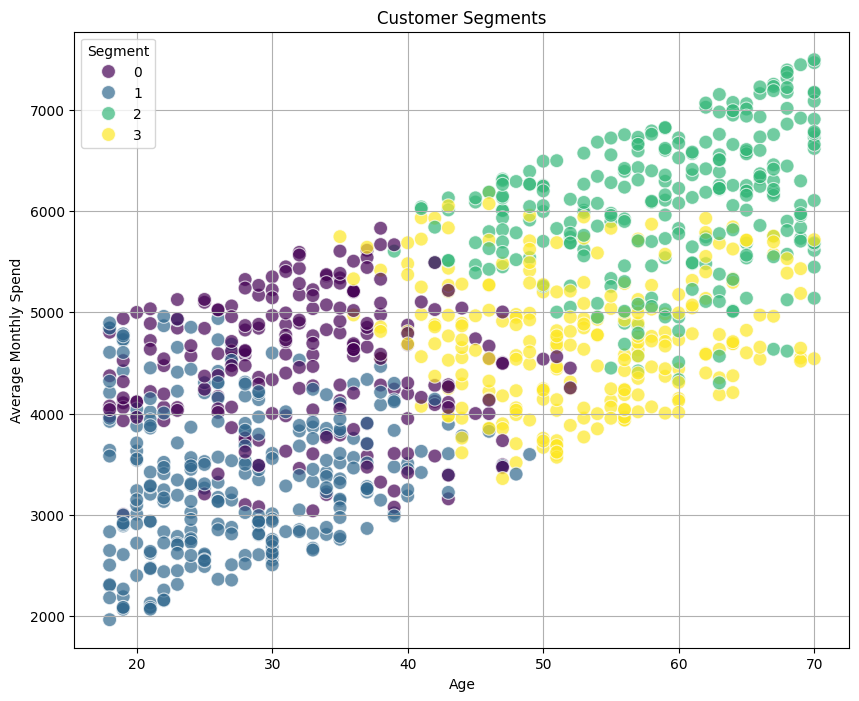

In [18]:

segment_analysis = df.groupby('segment')[features].mean()

print("\nAnalysis of each customer segment:")
print(segment_analysis)


plt.figure(figsize=(10, 8))
sns.scatterplot(data=df, x='age', y='avg_monthly_spend', hue='segment', palette='viridis', s=100, alpha=0.7)
plt.title('Customer Segments')
plt.xlabel('Age')
plt.ylabel('Average Monthly Spend')
plt.legend(title='Segment')
plt.grid(True)
plt.show()

In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


y = df['last_campaign_response']


features_to_include = [
    'age', 
    'avg_monthly_spend', 
    'items_purchased_last_6_months', 
    'last_seen_days_ago', 
    'segment', # Our new feature from Phase 2!
    'preferred_channel', 
    'preferred_timing'
]
X = df[features_to_include]


X = pd.get_dummies(X, columns=['preferred_channel', 'preferred_timing'], drop_first=True)

print("Data prepared for modeling. Features after One-Hot Encoding:")
print(X.head())

Data prepared for modeling. Features after One-Hot Encoding:
   age  avg_monthly_spend  items_purchased_last_6_months  last_seen_days_ago  \
0   27            4609.93                              3                 110   
1   46            4219.83                              3                 151   
2   35            5338.38                              5                  40   
3   70            5611.21                              7                 179   
4   23            5125.19                              5                  19   

   segment  preferred_channel_Email  preferred_timing_Morning (9 AM - 12 PM)  
0        1                    False                                    False  
1        3                     True                                     True  
2        0                     True                                    False  
3        2                     True                                     True  
4        0                    False                            

In [ ]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y 
)

print(f"\nData split into training and testing sets.")
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")


Data split into training and testing sets.
Training set size: 800 samples
Testing set size: 200 samples


In [21]:
# Initialize the Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

print("\nRandom Forest model trained successfully.")    


Random Forest model trained successfully.



Model Accuracy: 0.5500

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.46      0.48        90
           1       0.58      0.63      0.61       110

    accuracy                           0.55       200
   macro avg       0.54      0.54      0.54       200
weighted avg       0.55      0.55      0.55       200


Confusion Matrix:


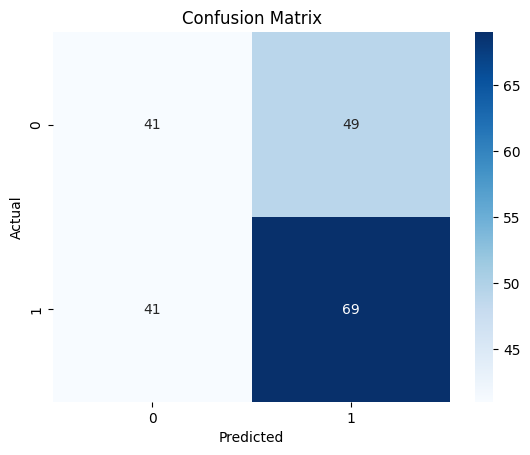

In [ ]:
# Make predictions on the test set
y_pred = rf_model.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

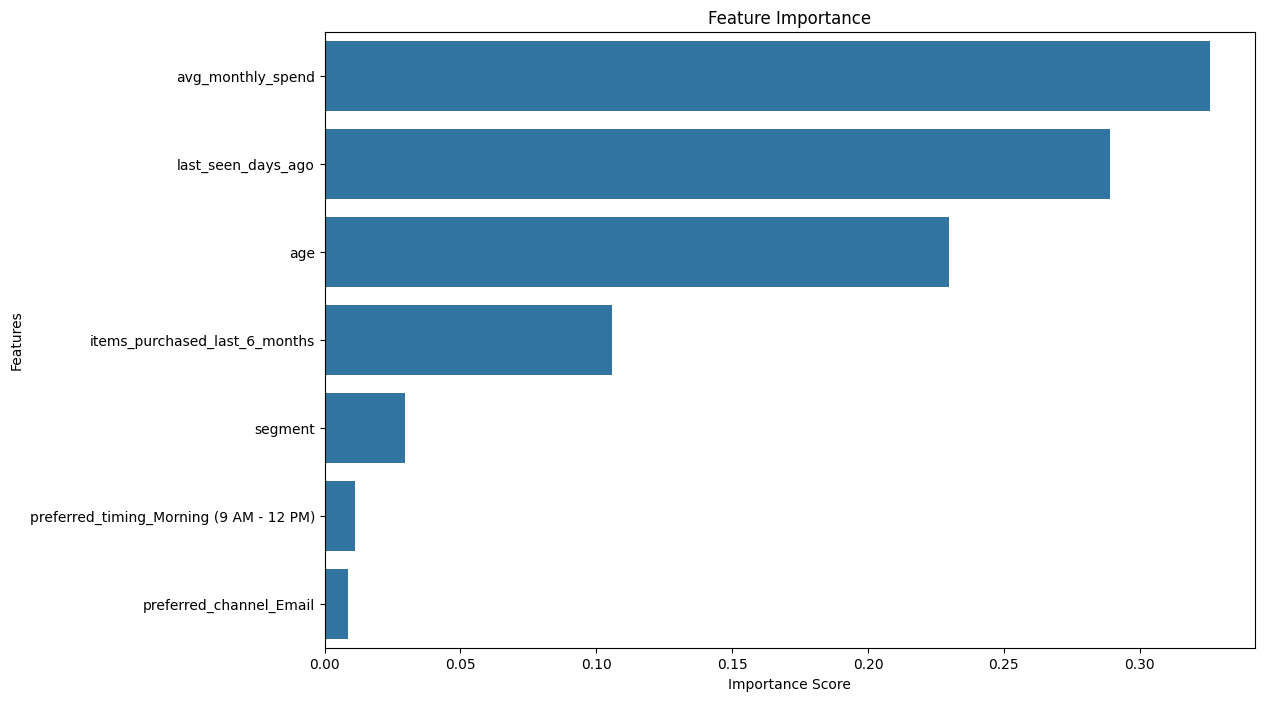

In [ ]:

importances = rf_model.feature_importances_
feature_names = X.columns


feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)


plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

In [24]:
import joblib
import os


output_dir = '../models'
os.makedirs(output_dir, exist_ok=True)


joblib.dump(rf_model, os.path.join(output_dir, 'rf_model.pkl'))
joblib.dump(kmeans, os.path.join(output_dir, 'kmeans_model.pkl'))
joblib.dump(scaler, os.path.join(output_dir, 'scaler.pkl'))


model_columns = list(X.columns)
joblib.dump(model_columns, os.path.join(output_dir, 'model_columns.pkl'))

print(f"All models and assets saved successfully to the '{output_dir}' directory.")

All models and assets saved successfully to the '../models' directory.
